In [3]:
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from Common import NeuralNet, fit

In [131]:
##### GLOBAL PARAMETERS #####

d = 1

x1_min, x1_max = -0, 1.0
x2_min, x2_max = -0.2, 1.0

dist_min, dist_max = 0.8, 1.2
# wl_min,   wl_max   = 20, 25

freq = 12

# Define the initial condition function
def u0(input_vector):
    u = np.abs(input_vector[0] - input_vector[2]/2.) < 0.1
    u = np.logical_or(u, np.abs(input_vector[0] + input_vector[2]/2.) < 0.1)
    u = np.logical_and(np.abs(input_vector[1]) < 0.1, np.logical_not(u))
    return u


# Define the solution function
def u(input_vector):
    u = np.sin(np.sqrt((input_vector[0] - input_vector[2]/2.)**2 + input_vector[1]**2) * freq) * 0.5
    u += np.sin(np.sqrt((input_vector[0] + input_vector[2]/2.)**2 + input_vector[1]**2) * freq) * 0.5
    u *= input_vector[1] >= 0
    u += (input_vector[1] < 0) * np.sin(input_vector[1] * freq)
    return u

# Parametric approach

In [65]:
##### GENERATE TRAINING INPUT #####

num_positions = 64**2
num_params = 32

# positions

soboleng_positions = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
input_positions = soboleng_positions.draw(num_positions*num_params).numpy()

input_positions[:, 0] *= (x1_max-x1_min)
input_positions[:, 0] += x1_min 
input_positions[:, 1] *= (x2_max-x2_min) 
input_positions[:, 1] += x2_min

# parameters

soboleng_params = torch.quasirandom.SobolEngine(dimension=d, scramble=True)
sobol_params = soboleng_params.draw(num_params).numpy()
# sobol_params = torch.rand((num_params, d))


sobol_params[:, 0] = sobol_params[:, 0] * (dist_max-dist_min) + dist_min 
# sobol_params[:, 0] = sobol_params[:, 0] * (wl_max-wl_min) + wl_min 

training_inputs = np.zeros((num_positions*num_params, 2+d))
training_inputs[:, 0] = input_positions[:, 0]
training_inputs[:, 1] = input_positions[:, 1]

for m in range(d):
    training_inputs[:, 2+m] = np.tile(sobol_params[:, m], num_positions).reshape(num_positions, num_params).transpose().flatten()

print(training_inputs.shape)
np.save("data/training_inputs.npy", training_inputs)


##### GENERATE TRAINING OUTPUT #####

training_outputs = u(training_inputs.transpose())
print(training_outputs.shape)
np.save("data/training_outputs.npy", training_outputs)

(131072, 3)
(131072,)


(131072, 3) (131072,)
[0.91002119 0.91002119 0.91002119 ... 0.91002119 0.91002119 0.91002119]


Text(0.5, 1.0, 'Solution at final time')

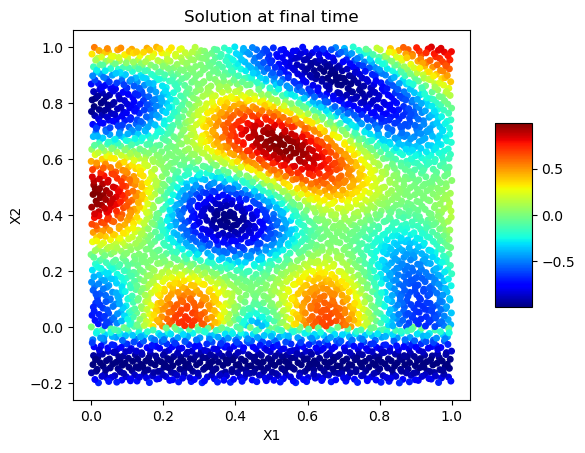

In [66]:
input_train = np.load("data/training_inputs.npy")
output_train = np.load("data/training_outputs.npy")

print(input_train.shape, output_train.shape)

param_idx = 8

in_test = input_train[num_positions*param_idx:num_positions*(param_idx+1), :]
X_test, Y_test = in_test[:, 0], in_test[:, 1]
print(in_test[:, 2])
out_test = output_train[num_positions*param_idx:num_positions*(param_idx+1)]

fig = plt.figure()

ax = fig.add_subplot(111)
surf = ax.scatter(X_test, Y_test, c=out_test, cmap=cm.jet, s=16)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Solution at final time')

/var/folders/nh/nwqmnrps0k3bdfzpk43xcwh40000gn/T/ipykernel_24917/2346009583.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_dataset = TensorDataset(torch.tensor(input_train_torch), torch.tensor(output_train_torch))


################################  0  ################################
Loss:  0.3921005926094949
################################  1  ################################
Loss:  0.2255258266814053
################################  2  ################################
Loss:  0.21182428859174252
################################  3  ################################
Loss:  0.20749537786468863
################################  4  ################################
Loss:  0.2051988053135574
################################  5  ################################
Loss:  0.203736518509686
################################  6  ################################
Loss:  0.20237819803878665
################################  7  ################################
Loss:  0.2011342914775014
################################  8  ################################
Loss:  0.19982016272842884
################################  9  ################################
Loss:  0.19846966909244657
################################  10

Text(0, 0.5, 'Loss')

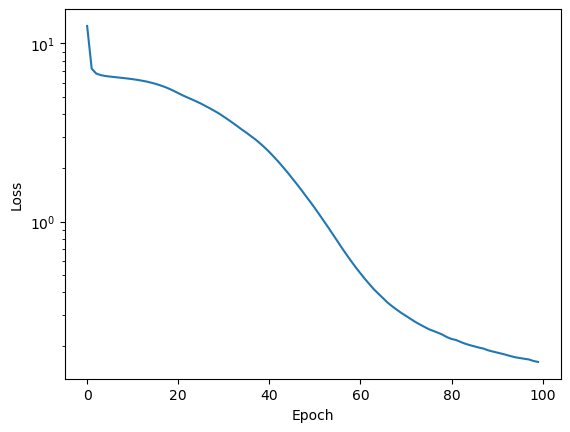

In [67]:
##### FINAL TRAINING DATA RETYPING #####

input_train_torch = torch.tensor(input_train, dtype=torch.float32)
output_train_torch = torch.tensor(output_train, dtype=torch.float32)
training_dataset = TensorDataset(torch.tensor(input_train_torch), torch.tensor(output_train_torch))
training_dataset_dl = DataLoader(training_dataset, batch_size=4096, shuffle=True)

##### MODEL DEFINITION #####

model = NeuralNet(
    input_dimension=2+d,
    output_dimension=1,
    n_hidden_layers=4,
    neurons=32,
    regularization_exp=0,
    regularization_param=0,
    retrain_seed=1
    )

##### TRAINING #####

learning_rate = 1e-3
num_epochs = 100

optimizer_ADAM = optim.Adam(
    model.parameters(),
    lr=float(learning_rate)
    )

history = fit(
    model=model,
    training_set=training_dataset_dl,
    num_epochs=num_epochs,
    optimizer=optimizer_ADAM,
    p=2,
    verbose=True
)

plt.plot(history)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")

Slits distance: tensor([0.9350])


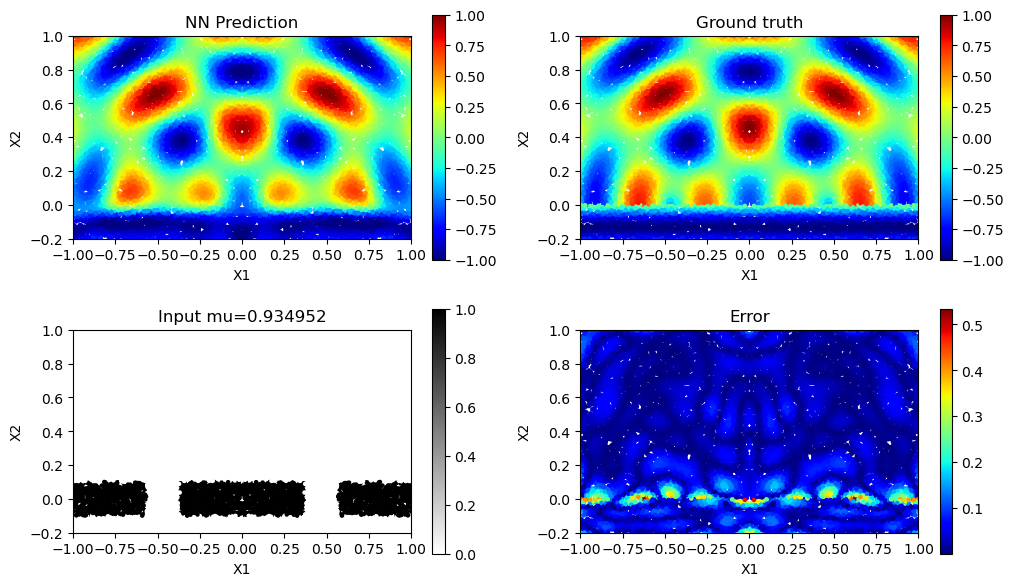

In [68]:
##### GENERATE TESTING DATA #####

num_positions_test = 10000
num_params_test    = 1

# positions

positions_test = np.random.random((num_positions_test,2))

positions_test[:, 0] *= (x1_max-x1_min)
positions_test[:, 0] += x1_min 
positions_test[:, 1] *= (x2_max-x2_min) 
positions_test[:, 1] += x2_min

# parameters

mu_test = torch.rand((1,d))

mu_test[:, 0] = mu_test[:, 0] * (dist_max-dist_min) + dist_min 
# mu_test[:, 0] = mu_test[:, 0] * (wl_max-wl_min) + wl_min 

print(f"Slits distance: {mu_test[0]}")

test_inputs = np.zeros((num_positions_test*num_params_test, 2+d))
test_inputs[:, 0] = np.tile(positions_test[:, 0], num_params_test)
test_inputs[:, 1] = np.tile(positions_test[:, 1], num_params_test)
for m in range(d):
    test_inputs[:, 2+m] = np.tile(mu_test[:, m], num_positions_test).reshape(num_positions_test, num_params_test).transpose().flatten()

prediction = np.array([model.forward(torch.tensor(test_inputs[i, :], dtype=torch.float32)).detach().item() for i in range(num_positions_test)])
ground_truth = u(test_inputs.transpose())

fig = plt.figure(figsize=(12, 7))

mirrored_inputs = np.concatenate((test_inputs, test_inputs * np.array([-1, 1, 1])), axis=0)
mirrored_prediction = np.concatenate((prediction, prediction), axis=0)
mirrored_ground_truth = np.concatenate((ground_truth, ground_truth), axis=0)

dot_size = 5

ax1 = fig.add_subplot(221)
im1 = ax1.scatter(mirrored_inputs[:, 0], mirrored_inputs[:, 1], c=mirrored_prediction, cmap=cm.jet, s=dot_size, vmin=-1, vmax=1)
plt.colorbar(im1)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('NN Prediction')
ax1.set_xlim(-x1_max, x1_max)
ax1.set_ylim(x2_min, x2_max)
ax1.set_aspect(1)

ax2 = fig.add_subplot(222)
im2 = ax2.scatter(mirrored_inputs[:, 0], mirrored_inputs[:, 1], c=mirrored_ground_truth, cmap=cm.jet, s=dot_size, vmin=-1, vmax=1)
plt.colorbar(im2)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('Ground truth')
ax2.set_xlim(-x1_max, x1_max)
ax2.set_ylim(x2_min, x2_max)
ax2.set_aspect(1)

ax3 = fig.add_subplot(224)
im3 = ax3.scatter(mirrored_inputs[:, 0], mirrored_inputs[:, 1], c=np.abs(mirrored_ground_truth - mirrored_prediction), cmap=cm.jet, s=dot_size)
plt.colorbar(im3)
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_title('Error')
ax3.set_xlim(-x1_max, x1_max)
ax3.set_ylim(x2_min, x2_max)
ax3.set_aspect(1)

ax4 = fig.add_subplot(223)
im4 = ax4.scatter(mirrored_inputs[:, 0], mirrored_inputs[:, 1], c=u0(mirrored_inputs.T), cmap=cm.binary, s=dot_size)
plt.colorbar(im4)
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.set_title(f'Input mu={mu_test.numpy()[0,0]:2f}')
ax4.set_xlim(-x1_max, x1_max)
ax4.set_ylim(x2_min, x2_max)
ax4.set_aspect(1)

plt.show()

# Operator approach

In [69]:
##### 2D FOURIER LAYER #####

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, fno_architecture, device=None, padding_frac=1 / 4):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.modes1 = fno_architecture["modes"]
        self.modes2 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.retrain_fno = fno_architecture["retrain_fno"]

        torch.manual_seed(self.retrain_fno)
        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        
        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

        self.to(device)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1_padding = int(round(x.shape[-1] * self.padding_frac))
        x2_padding = int(round(x.shape[-2] * self.padding_frac))
        x = F.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [132]:
discretization = 64

x1_points = torch.linspace(x1_min, x1_max, discretization)
x2_points = torch.linspace(x2_min, x2_max, discretization)

position_grid = torch.stack(torch.meshgrid(x1_points, x2_points),axis=2).reshape((discretization, discretization, 2))

d = 1
n_samples = 32

param_samples = torch.rand((n_samples, d))

param_samples[:, 0] = param_samples[:, 0] * (dist_max-dist_min) + dist_min 
# param_samples[:, 0] = param_samples[:, 0] * (wl_max-wl_min) + wl_min 

fno_input_positions = torch.tile(torch.flip(position_grid.reshape((1, discretization**2, 2)), [-1]), (n_samples, 1, 1))
# print(fno_input_positions.shape)
fno_input_params = torch.tile(param_samples.reshape(n_samples, 1, d), (1, discretization**2, 1))
# print(fno_input_params.shape)
fno_input_vectors = torch.concatenate((fno_input_positions, fno_input_params), axis=-1).reshape(n_samples*discretization*discretization, 2+d)
# print("fno_input_vectors ", fno_input_vectors.shape)

fno_input_train = torch.concatenate( (
        u0(np.transpose(fno_input_vectors)).reshape((n_samples, discretization, discretization, 1)), 
        fno_input_vectors[:, 0].reshape((n_samples, discretization, discretization, 1)),
        fno_input_vectors[:, 1].reshape((n_samples, discretization, discretization, 1))
    ), axis=-1)

fno_output_train = u(np.transpose(fno_input_vectors)).reshape((n_samples, discretization, discretization, 1))

print("input:", fno_input_train.shape)
print("output:", fno_output_train.shape)

# np.savetxt("fno_input_vectors.csv", np.array(fno_input_vectors.detach()), delimiter=',')

n_train = int(0.8*n_samples)
print("n_train = ", n_train)

input_function_train = fno_input_train[:n_train, :, :, :]
output_function_train = fno_output_train[:n_train, :, :, :]
input_function_test = fno_input_train[n_train:, :, :, :]
output_function_test = fno_output_train[n_train:, :, :, :]

batch_size = 64

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

print(input_function_train.shape)
print(output_function_train.shape)
print(input_function_test.shape)
print(output_function_test.shape)

input: torch.Size([32, 64, 64, 3])
output: torch.Size([32, 64, 64, 1])
n_train =  25
torch.Size([25, 64, 64, 3])
torch.Size([25, 64, 64, 1])
torch.Size([7, 64, 64, 3])
torch.Size([7, 64, 64, 1])


######### Epoch: 0  ######### Train Loss: 0.23549777269363403  ######### Relative L2 Test Norm: 99.05091857910156
######### Epoch: 1  ######### Train Loss: 0.2331600934267044  ######### Relative L2 Test Norm: 98.45516967773438
######### Epoch: 2  ######### Train Loss: 0.2305014431476593  ######### Relative L2 Test Norm: 97.76663970947266
######### Epoch: 3  ######### Train Loss: 0.22748638689517975  ######### Relative L2 Test Norm: 96.8582534790039
######### Epoch: 4  ######### Train Loss: 0.22357827425003052  ######### Relative L2 Test Norm: 95.68891143798828
######### Epoch: 5  ######### Train Loss: 0.21862106025218964  ######### Relative L2 Test Norm: 94.24060821533203
######### Epoch: 6  ######### Train Loss: 0.21257707476615906  ######### Relative L2 Test Norm: 92.49628448486328
######### Epoch: 7  ######### Train Loss: 0.20543155074119568  ######### Relative L2 Test Norm: 90.44215393066406
######### Epoch: 8  ######### Train Loss: 0.19720356166362762  ######### Relative L2 Test N

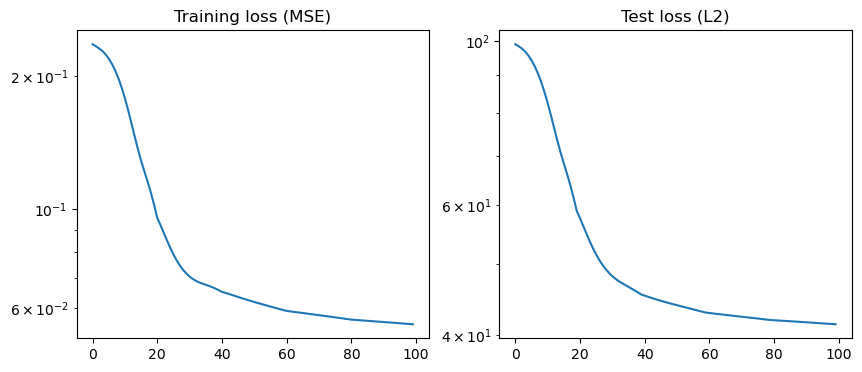

In [181]:
learning_rate = 0.001

epochs = 100
step_size = 20
gamma = 0.5

fno_architecture = {
    "modes": 8,
    "width": 32,
    "n_layers": 2,
    "retrain_fno": 1
}

fno = FNO2d(fno_architecture)

optimizer = optim.Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_loss_mse = []
test_loss_l2 = []

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)
    train_loss_mse.append(train_mse)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)
        test_loss_l2.append(test_relative_l2)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)

ax1.plot(train_loss_mse)
ax1.set_title("Training loss (MSE)")
ax1.set_yscale('log')
ax2.plot(test_loss_l2)
ax2.set_title("Test loss (L2)")
ax2.set_yscale('log')

torch.Size([64, 64])
torch.Size([64, 64])


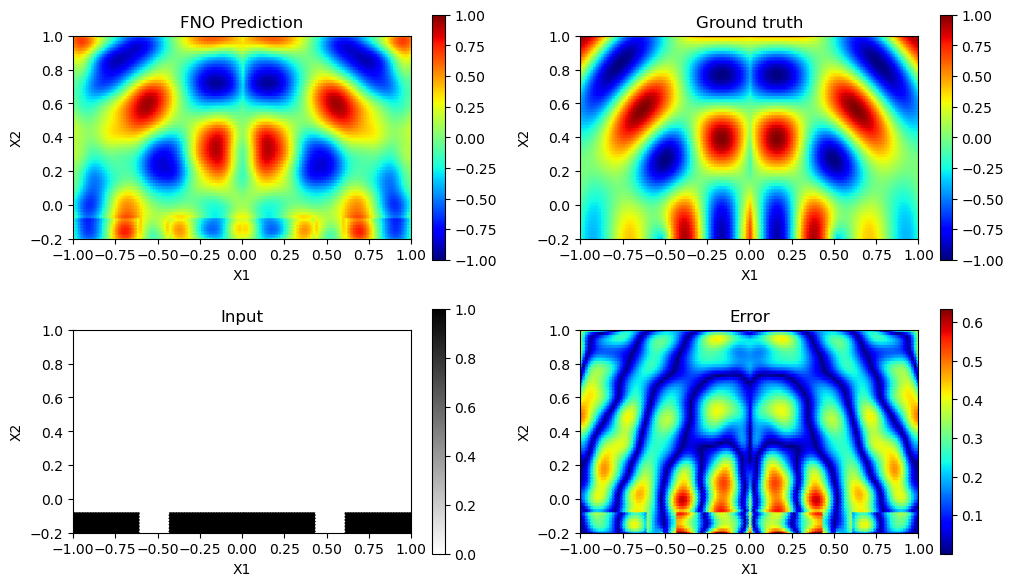

In [182]:
k = 1

test_input = fno_input_train[k:k+1, :, :, :]
# input_FNO  = test_input[k:k+1, :, :, 0]

prediction = fno.forward(test_input).reshape((discretization, discretization))
ground_truth = fno_output_train[k, :, :, :].reshape((discretization, discretization))

print(prediction.shape)
print(ground_truth.shape)

xx, yy = np.meshgrid(x1_points, x2_points)

fig = plt.figure(figsize=(12, 7))

mirrored_xx = np.concatenate((xx, xx * -1), axis=0)
mirrored_yy = np.concatenate((yy, yy), axis=0)

dot_size = 5

ax1 = fig.add_subplot(221)
im1 = ax1.scatter(mirrored_xx, mirrored_yy, c=np.concatenate((prediction.detach().numpy(),prediction.detach().numpy())), cmap=cm.jet, s=dot_size, vmin=-1, vmax=1)
plt.colorbar(im1)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('FNO Prediction')
ax1.set_xlim(-x1_max, x1_max)
ax1.set_ylim(x2_min, x2_max)
ax1.set_aspect(1)

ax2 = fig.add_subplot(222)
im2 = ax2.scatter(mirrored_xx, mirrored_yy, c=np.concatenate((ground_truth.detach().numpy(),ground_truth.detach().numpy())), cmap=cm.jet, s=dot_size, vmin=-1, vmax=1)
plt.colorbar(im2)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('Ground truth')
ax2.set_xlim(-x1_max, x1_max)
ax2.set_ylim(x2_min, x2_max)
ax2.set_aspect(1)

err_FNO = np.abs(ground_truth.detach().numpy()-prediction.detach().numpy())

ax3 = fig.add_subplot(224)
im3 = ax3.scatter(mirrored_xx, mirrored_yy, c=np.concatenate((err_FNO,err_FNO)), cmap=cm.jet, s=dot_size)
plt.colorbar(im3)
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_title('Error')
ax3.set_xlim(-x1_max, x1_max)
ax3.set_ylim(x2_min, x2_max)
ax3.set_aspect(1)

input_u0_FNO = test_input[0, :, :, 0].detach().numpy().reshape((discretization**2))
input_u0_FNO = np.concatenate((input_u0_FNO, input_u0_FNO))

ax4 = fig.add_subplot(223)
im4 = ax4.scatter(mirrored_xx, mirrored_yy, c=input_u0_FNO, cmap=cm.binary, s=dot_size)
plt.colorbar(im4)
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.set_title(f'Input')
ax4.set_xlim(-x1_max, x1_max)
ax4.set_ylim(x2_min, x2_max)
ax4.set_aspect(1)

plt.show()